In [7]:
import os
import time
import numpy as np
import pandas as pd
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from hyperopt import hp
from hyperopt.pyll import scope

from src.Services.DataProcessService import DataProcessService
from src.Services.LoadDataFrameService import LoadDataFrameService
from src.Services.HyperparameterOptimizationService import HyperparameterOptimizationService
from src.Visualizations.LearningCurveVisualizer import LearningCurveVisualizer
from src.Visualizations.PredictionRangeAccuracyVisualizer import PredictionVisualizationService
from src.Visualizations.PredictionRangeEvaluatorVisualizer import PredictionRangeEvaluatorVisualizer

In [8]:
MODEL_NAME = 'model_5_days_correct.keras'
# MODEL_NAME = None
SEQUENCE_LENGTH = 30
DATA_PATH = 'assets/crypto-data.csv'
MODELS_DIR = os.path.join(os.curdir, "assets/models")
LOSS_METHOD = 'huber'

# Wczytanie danych

In [9]:
df = (LoadDataFrameService(DATA_PATH)).load_dataframe()

data_processor = DataProcessService(sequence_length=SEQUENCE_LENGTH)

X_full, y_full = data_processor.create_sequences(df)
X_train, y_train, X_val, y_val, X_test, y_test = data_processor.split_data(X_full, y_full)

In [10]:
print(f"Test:       X={X_test.shape},  y={y_test.shape}")
print(f"Train:      X={X_train.shape}, y={y_train.shape}")
print(f"Validation: X={X_val.shape},   y={y_val.shape}")

Test:       X=(262, 30, 13),  y=(262, 3)
Train:      X=(2119, 30, 13), y=(2119, 3)
Validation: X=(236, 30, 13),   y=(236, 3)


# Model podstawowy


## Definiujemy model

In [11]:
def build_basic_dense_model(hparams):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    for i in range(hparams['hidden_layers']):
        units = hparams[f'units_layer{i}']
        model.add(keras.layers.Dense(units))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(hparams['activation']))  
        model.add(keras.layers.Dropout(hparams['dropout_rate']))

    model.add(keras.layers.Dense(3))

    optimizer = keras.optimizers.get(hparams['optimizer'])
    optimizer.learning_rate = hparams['lr']

    model.compile(optimizer=optimizer, loss=LOSS_METHOD)
    return model

## Przestrzeń hiperparametrów

In [12]:
space = {
    'epochs': 2,
    'hidden_layers': hp.randint('num_layers', 3, 5),
    'units_layer0': hp.randint('units_layer0', 1024, 4096),
    'units_layer1': hp.randint('units_layer1', 1024, 2048),
    'units_layer2': hp.randint('units_layer2', 64, 1024),
    'units_layer3': hp.randint('units_layer3', 64, 512),
    'units_layer4': hp.randint('units_layer4', 32, 256),
    'units_layer5': hp.randint('units_layer5', 16, 128),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'activation': hp.choice('activation', ['relu', 'elu', 'selu', 'swish']),
    'optimizer': hp.choice('optimizer', ['Adam', 'Nadam', 'RMSprop']),
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-2)),
    'batch_size': scope.int(hp.quniform('batch_size', 32, 256, 32)),
}

## Szukamy najlepszego

In [13]:
if MODEL_NAME is None:
    optimizer_service = HyperparameterOptimizationService(X_train, y_train, X_val, y_val, build_basic_dense_model)
    best_params, best_model, trials = optimizer_service.optimize(space, max_evals=2)

    print("Najlepsze hiperparametry:")
    print(best_params)

## Budujemy wybrany już najlepszy model większą liczbą epok

In [14]:
model = None

if MODEL_NAME is None:
    model = best_model

    model.summary()
else:
    model = keras.models.load_model(f"{MODELS_DIR}/{MODEL_NAME}")

2025-04-23 18:53:01.071975: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
model.layers

[<Flatten name=flatten_52, built=True>,
 <Dense name=dense_194, built=True>,
 <BatchNormalization name=batch_normalization_144, built=True>,
 <Activation name=activation_144, built=True>,
 <Dense name=dense_195, built=True>]

In [16]:
if MODEL_NAME is None:
    optimizer_name = best_params['optimizer']
    optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
    optimizer = optimizer_class(learning_rate=best_params['lr'])

    model.compile(optimizer=optimizer, loss=LOSS_METHOD)

In [17]:
model_id = time.strftime("model_%Y_%m_%d-%H_%M_%S")
model_path = f"{MODELS_DIR}/{model_id}.keras"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)

class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nwalidacja/uczenie: {:.2f}".format(logs["val_loss"] / logs["loss"]))

print_val_train_ratio_cb = PrintValTrainRatioCallback()

In [18]:
history = None
if MODEL_NAME is None:
    history = model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=best_params['batch_size'],
        validation_data=(X_val, y_val),
        callbacks=[
            checkpoint_cb,
            early_stopping_cb,
            print_val_train_ratio_cb
        ]
    )

In [19]:
if history is not None:
    plot = LearningCurveVisualizer(history)
    plot.visualize()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


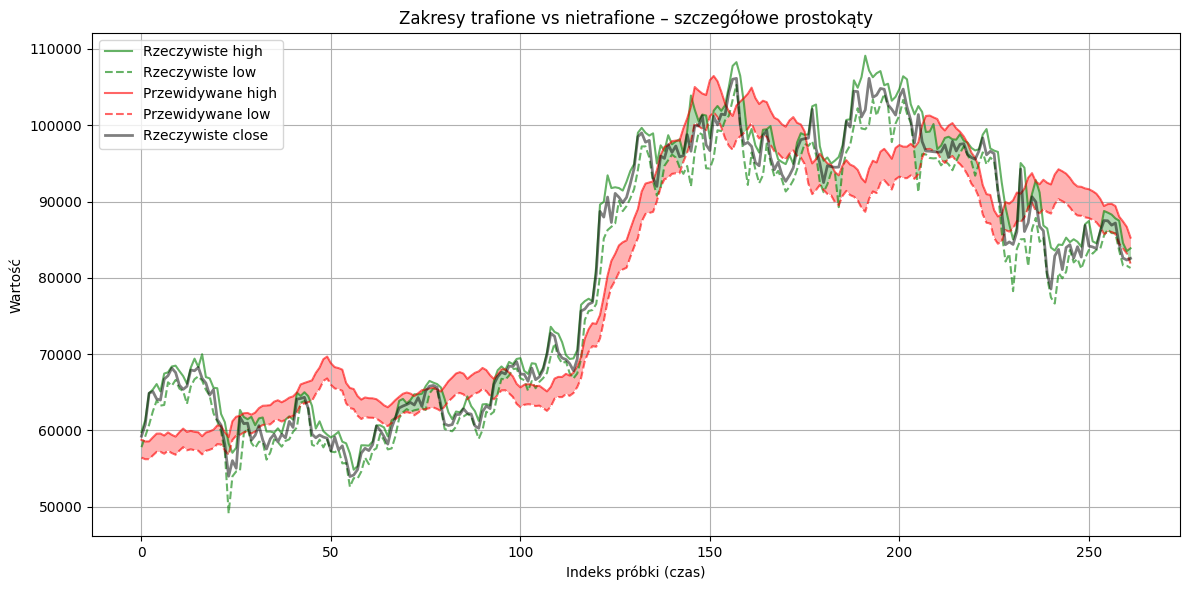

In [20]:
predictions = model.predict(X_test)
plot = PredictionVisualizationService(y_test, predictions)
plot.visualize()

In [21]:
evaluator = PredictionRangeEvaluatorVisualizer(y_test, predictions)
evaluator.print_summary()

Dokładność predykcji zakresu: 23.66%
Średnia szerokość zakresu: 3370.62
Liczba przypadków powyżej high: 102
Liczba przypadków poniżej low: 98
Średnie odchylenie powyżej high: 4797.92
Średnie odchylenie poniżej low: 3252.76


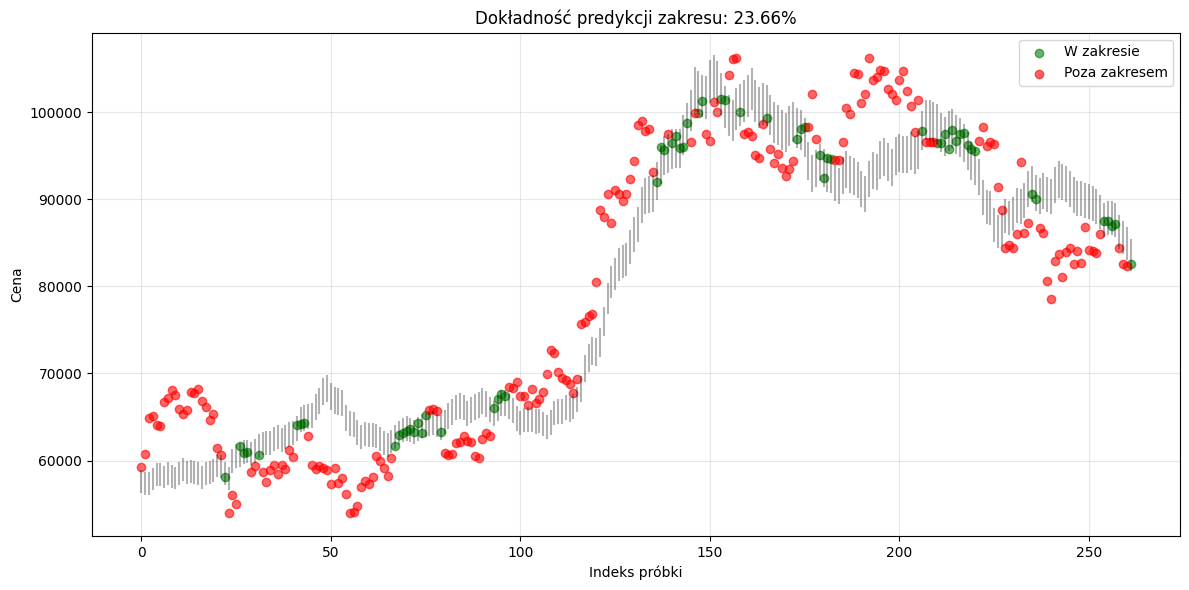

In [22]:
evaluator.plot_range_accuracy()